In [2]:
%matplotlib inline

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [4]:
def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        print(segment)
        yield segment, get_subimage(img, mask == segment)
        
def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        replacements[segment_idx] = np.median(mask_subimg[:,:,1])
        
    flat_mask = mask.flatten()
    return pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape)

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def get_palette(hls_palette):
    paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[1], cl[2]), hls_palette))
    
    return paleta

def quantize_img(palette_index_matrix, palette=np_itten_color_wheel):
    shape = palette_index_matrix.shape
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [5]:
def get_img(img_path):
    img = cv2.imread(img_path)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    
    return img_rgb, img_hls

# Paleta de Analisis

In [9]:
steps = 20
limit = 100

paleta_luminancia = np.array([
    (250/360, i/limit, 0)
    for i in range(0, limit, int(limit/steps))
])

In [12]:
def preprocess_luminance(img_hls):
    return img_hls * (0, 1/255, 0)

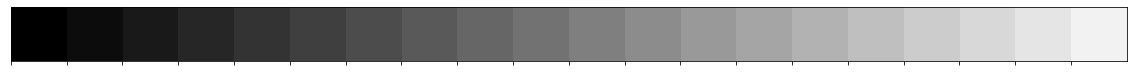

In [10]:
sns.palplot(get_palette(paleta_luminancia))

# Carga archivos

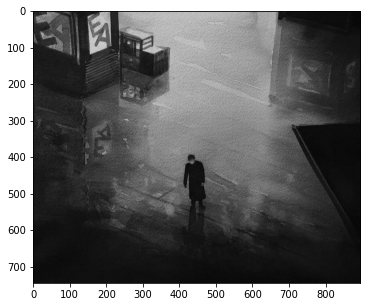

In [26]:
plt.imshow(img_rgb)

In [14]:
def get_image_signatures(img_list, preprocess=preprocess_luminance, analysis_palette=np_itten_color_wheel):
    signatures = []
    for img_path in tqdm(img_list):
        img_rgb, img_hls = get_img(img_path)

        quantized_img = get_color_wheel_quantized_img(preprocess(img_hls), analysis_palette)
        signature = dict(zip(*np.unique(quantized_img, return_counts=True)))
        
        signatures.append(signature)
        
    return signatures

In [15]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [18]:
signatures = get_image_signatures(cam, analysis_palette=paleta_luminancia)

100%|██████████| 1537/1537 [02:33<00:00,  9.99it/s]


In [19]:
pd_signatures = pd.DataFrame(signatures)

In [20]:
pd_weighted_signatures = pd_signatures.apply(lambda x: x/x.sum(), axis=1)

<AxesSubplot:>

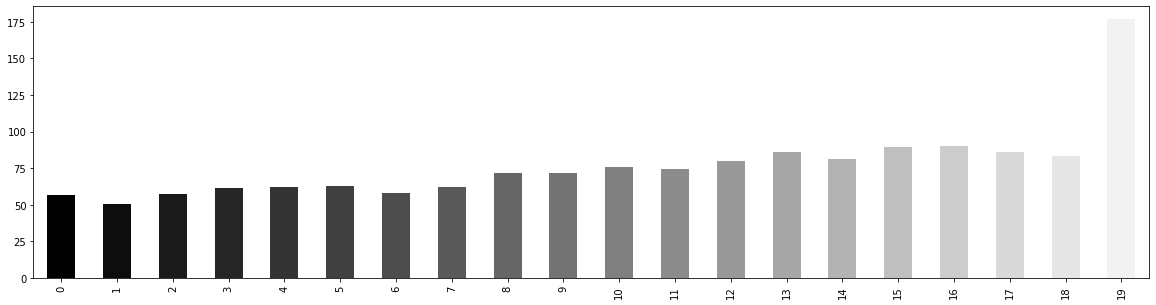

In [22]:
pd_weighted_signatures.sum(axis=0).plot.bar(color=get_palette(paleta_luminancia))

# Pruebas Luminancia y posicion

In [23]:
def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [31]:
img = cam[0]
img_rgb, img_hls = get_img(img)

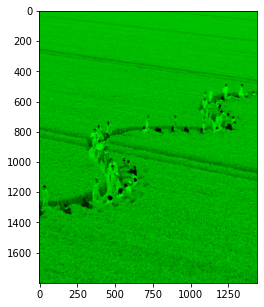

In [33]:
plt.imshow(preprocess_luminance(img_hls), cmap='gray')